https://arxiv.org/ftp/arxiv/papers/1305/1305.6143.pdf

In [2]:
import pandas as pd
import pathlib
import shlex
import re
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import csv

from nltk.tokenize import sent_tokenize
from nltk.stem import SnowballStemmer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
def clean_text_for_language_model(text, remove_users=True, remove_urls=True, remove_numbers=True):
    """
    Cleans text for deep learning language models, applies pre tokenization

    :param text: Str, text string

    :return: cleaned string
    """

    re_repetition = re.compile(r'(\S)(\1{3,})') #repetition of multiple non-whitespace characters
    re_word_repetition = re.compile(r'(\b\w+\W+)(\1{3,})') #repetition of multiple words

    s = text
    s = re_repetition.sub(replace_repeated_character, s)
    s = re_word_repetition.sub(replace_repeated_word, s)
    s = lower_and_add_toks_for_case(s)
    s = add_spaces_to_hashtags_and_slashes(s)
    s = remove_multiple_whitespace_from_string(s)
    s = add_start_of_doc_tokens(s)
    s = replace_repeated_punc(s)
    if remove_numbers:
        s = replace_numbers(s)
    if remove_users:
        s = extract_mentioned_users(s,
                                    remove_users=False,
                                    replace_with_token=True,
                                    token_to_replace='[USER]')[0]
    if remove_urls:
        s = extract_urls(s,
                         remove_urls=False,
                         replace_with_token=True,
                         token_to_replace='[URL]')[0]
    return s


def replace_repeated_character(m):
    """
    The expression to sub for repeated letters

    :param m: the match of the regex

    :return: substituted string
    """
    TK_REP = '_tk_rep_char_'
    c, cc = m.groups()
    return f' {TK_REP} {len(cc)+1} {c} '


def replace_repeated_word(m):
    """
    The expression to sub for repeated words

    :param m: the match of the regex

    :return: substituted string
    """
    TK_WREP = '_tk_rep_word_'
    c, cc = m.groups()
    return f' {TK_WREP} {len(cc.split())+1} {c} '


def replace_repeated_punc(s):
    """
    Replace repeated punctuation and newline characters

    :param s: text string

    :return: modified text string
    """
    s = re.sub(r'([^\w\d\s]|\n)(\s\1)+', r'_multi_punc_ \1', s)
    return s


def remove_multiple_whitespace_from_string(s):
    s = re.sub(' {2,}', ' ', s)
    return s


def add_spaces_to_hashtags_and_slashes(s):
    s = re.sub(r'([/#])', r' \1 ', s)
    return s


def add_start_of_doc_tokens(s):
    TOK_DOC, TOK_SEC = '_tk_doc_', '_tk_section_'

    for size, section_start in re.findall(r'\n\s((?:=\s)*=)\s([^=]+)\s\1\s\n', s):
        if size == '=':
            token = TOK_DOC
        else:
            token = TOK_SEC

        s = re.sub(re.escape(size + ' ' + section_start + ' ' + size), token + ' ' + section_start + '.', s)

    return s


def lower_and_add_toks_for_case(s):
    TOK_UP, TOK_SENT, TOK_MIX = ' _tk_up_ ', ' _tk_st_ ', ' _tk_mx_ '
    res = []
    prev = '.'
    re_word = re.compile('\w')
    re_nonsp = re.compile('\S')
    for token in re.findall(r'\w+|\W+', s):
        if token.isupper() and len(token) > 2:
            res += [TOK_UP, token.lower()]
        else:
            res += [token.lower()]
    return ''.join(res)


def replace_numbers(s):
    TOK_NUM = '_number_'

    s = re.sub(r'[0-9]+', TOK_NUM, s)

    return s


def fixup(s):
    re1 = re.compile(r'  +')
    s = s.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(s))


def tokenizer_word(text_string,
                   keep_phrases=False,
                   tokenize_punc=False,
                   split_clitics=False,
                   keep_preceeding_space=False):
    """
    Tokenizer that tokenizes a string of text on spaces and new lines (regardless of however many of each.)

    :param text_string: Python string object to be tokenized.
    :param keep_phrases: Booalean will not split "quoted" text
    :param tokenize_punc: Boolean, if true will tokenize punctuation so "hello," becomes ["hello", ","]
    :param split_clitics: Boolean, if true will split tokens such as "I'm" into [I, 'm], must be tokenizing punctuation

    :return: Array of strings, each is a word
    """

    text_string = str(text_string)

    if keep_phrases:
        tokens = shlex.split(text_string.replace('\n', ' ').replace('/', ' '))
    elif tokenize_punc:
        if split_clitics:
            if keep_preceeding_space:
                tokens = regex.findall(
                    r"(?<!\s)'[\w]*"  # an apostrophe and potentially some other charaters, that come after non-whitespace
                    "|\s?'"  # an apostrophe, preceeded by whitespace
                    "|\s?[\w]+"  # one or more word characters
                    "|\s?[.,!?\-;=\n]"  # any single character of [.,!?\-;=\n]
                    "| \X"
                    "|\X"
                    , text_string, re.UNICODE)
            else:
                tokens = re.findall(r"(?<!\s)'[\w]*|(?<=\s)'|[\w]+|[.,!?\-;=\n]", text_string, re.UNICODE)
        else:
            tokens = re.findall(r"[\w']+|[.,!?\-;=\n]", text_string)
    else:
        tokens = text_string.replace('\n', ' ').replace('/', ' ').split()

    return tokens


def extract_mentioned_users(text_string,
                            remove_users=False,
                            replace_with_token=True,
                            token_to_replace='[USER]'):
    """
    Extracts mentioned_users from a text_string

    :param text_string: String of text you wish to extract mentioned_users from
    :param remove_users: Boolean, if True it will remove the mentioned_users from the text_string
    :param replace_with_token: Boolean, replace the users in the original string with a marker token
    :param token_to_replace: Str, the token to replace the user

    :return: text_sting: Sting as input but with mentioned_users removed if specified
    :return: mentioned_users: List of unique mentioned_users in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    mentioned_users = list(set(re.findall(r"@\w+", text_string)))

    if replace_with_token:
        text_string = re.sub(r"@\w+",
                             token_to_replace,
                             text_string)

    if remove_users and not replace_with_token:
        text_string = re.sub(r"@\w+",
                             '',
                             text_string)

    return text_string, mentioned_users


def extract_urls(text_string,
                 remove_urls=False,
                 replace_with_token=True,
                 token_to_replace='[URL]'):
    """
    Extracts url from a text_string

    :param text_string: String of text you wish to extract url from
    :param remove_urls: Boolean, if True it will remove the url from the text_string
    :param replace_with_token: Boolean, replace the urls in the original string with a marker token
    :param token_to_replace: Str, the token to replace the url

    :return: text_sting: Sting as input but with urls removed if specified
    :return: urls: List of unique urls in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    urls = list(set(re.findall(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                               text_string)))

    if replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             token_to_replace,
                             text_string)

    if remove_urls and not replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             '',
                             text_string)

    return text_string, urls

def negate_sequence_stem(text, stemmer):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    result = stemmer.stem_text(tokens=result)
    return result


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def tokenizer_sentence(text_string):
    """
    Tokenizer that tokenizes a string of text into sentences

    :param text_string: Python string object to be tokenized.
    :return: Array of strings, each is a sentence
    """

    sent_tokenize_list = sent_tokenize(text_string)

    return sent_tokenize_list
    
class Stemmer():

    def __init__(self, language='english'):
        """
        :param language: String representing the language to be used
        """

        self.stemmer = None

        try:
            self.stemmer = SnowballStemmer(language)
        except ValueError as e:
            print(
                'Invalid language supplied to the stemmer, please choose from: ' + " ".join(SnowballStemmer.languages) +
                '\nOr add a new stemmer to the repository ;)')

    def stem_text(self,
                  text_string=None,
                  tokens=None,
                  pos_tuples=False,
                  check_trailing=True,
                  tokens_to_ignore=None):
        """
        Function that stems a text string using the NLTK snowball stemmer

        :param text_string: Python string object to be tokenized and stemmed
        :param tokens: Python list of strings already tokenized
        :param pos_tuples: Bool, if tokens are a list of pos_tuples set this to true
        :param tokens_to_ignore: List of Str, tokens to avoid cleaning

        :return: String comparable to the input but with all words stemmed.
        """

        if not tokens_to_ignore:
            tokens_to_ignore = ["[USER]", "[HASHTAG]", "[URL]"]

        if tokens is None:
            tokens = []
        if text_string is not None:
            tokens = tokenizer_word(text_string,
                                    tokens_to_ignore=tokens_to_ignore)
            tokens = [self.stemmer.stem(token) if token not in tokens_to_ignore else token for token in tokens]
            stemmed = " ".join(tokens)
        else:
            stemmed = [self.stemmer.stem(token) for token in tokens]

        return stemmed
    
def negate_sequence(text):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    return result

# Initial look into which architecture is better with generally good hyperpaprams of c=10 and f=3

['i', 'was', 'hope', 'this', 'not_b', 'over', 'quick']
['not_w', 'all', 'just', 'be', 'friend', '?']
original
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2460 1394 1146]
 [1634 2048 1318]
 [1578 1403 2019]]


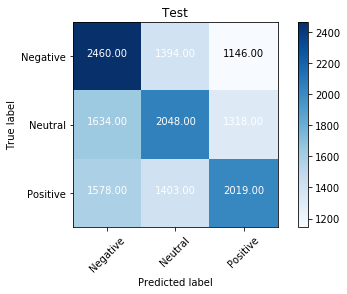

f1 score 0.4351333333333333
negation
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2389 1396 1215]
 [1658 2023 1319]
 [1505 1418 2077]]


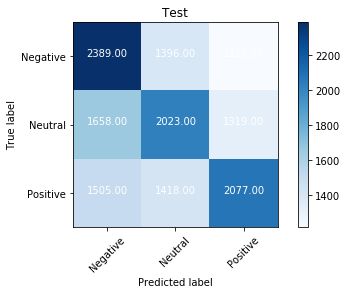

f1 score 0.4326
bernoulli
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2194 1750 1056]
 [1569 2184 1247]
 [1485 1605 1910]]


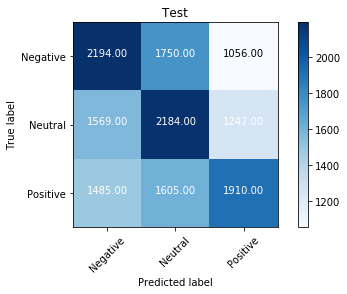

f1 score 0.4192
bernoulli_ngrams
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2242 1620 1138]
 [1666 2069 1265]
 [1535 1571 1894]]


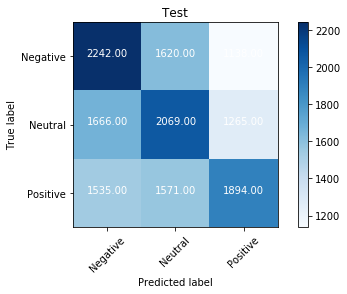

f1 score 0.4136666666666666
bernoulli_negate
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2236 1630 1134]
 [1612 2103 1285]
 [1474 1573 1953]]


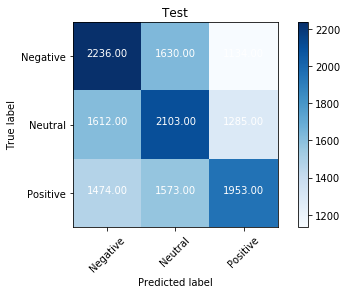

f1 score 0.41946666666666665
bernoulli_ngrams_negate
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2300 1536 1164]
 [1639 2011 1350]
 [1497 1500 2003]]


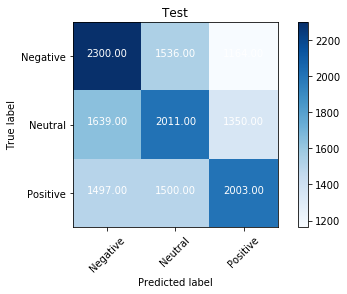

f1 score 0.4209333333333333
tfidf
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2315 1505 1180]
 [1627 2000 1373]
 [1337 1512 2151]]


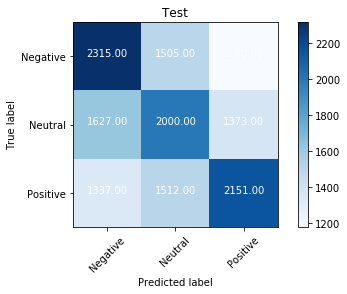

f1 score 0.43106666666666665
tfidf_ngrams
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2241 2446  313]
 [1430 3344  226]
 [1439 2682  879]]


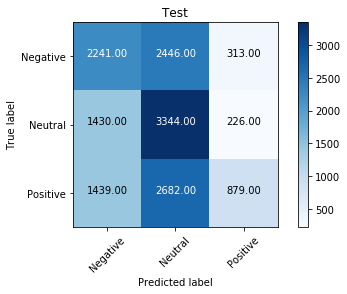

f1 score 0.43093333333333333
tfidf_negate
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2252 1460 1288]
 [1646 1979 1375]
 [1351 1459 2190]]


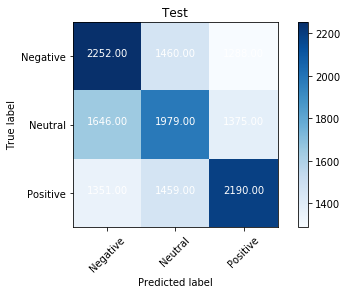

f1 score 0.42806666666666665
tfidf_ngrams_negate
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2242 1579 1179]
 [1608 2033 1359]
 [1448 1555 1997]]


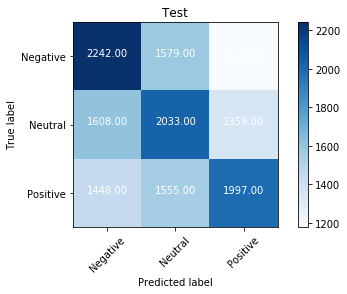

f1 score 0.41813333333333336
original
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2169 1909  922]
 [1486 2625  889]
 [1421 1903 1676]]


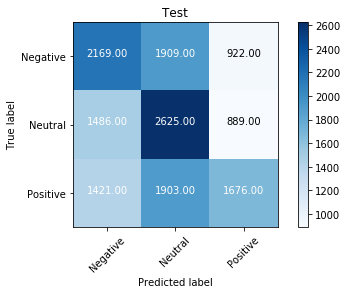

f1 score 0.43133333333333335
negation
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2137 1889  974]
 [1461 2613  926]
 [1395 1902 1703]]


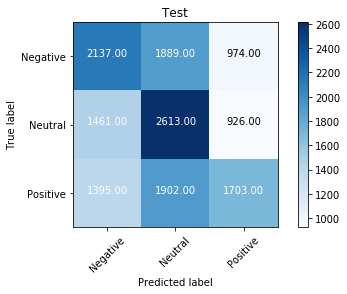

f1 score 0.4302
bernoulli
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2378 1489 1133]
 [1546 2118 1336]
 [1268 1491 2241]]


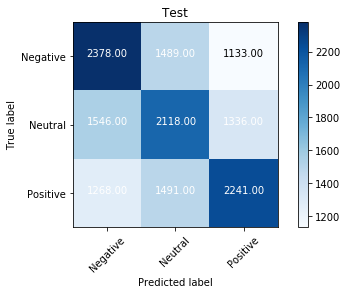

f1 score 0.44913333333333333
bernoulli_ngrams
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2350 1436 1214]
 [1608 2054 1338]
 [1362 1502 2136]]


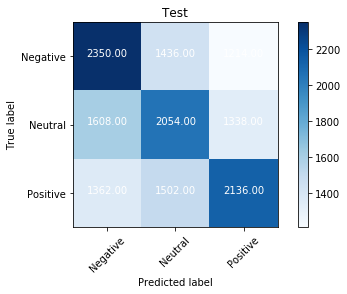

f1 score 0.436
bernoulli_negate
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2334 1536 1130]
 [1552 2163 1285]
 [1297 1561 2142]]


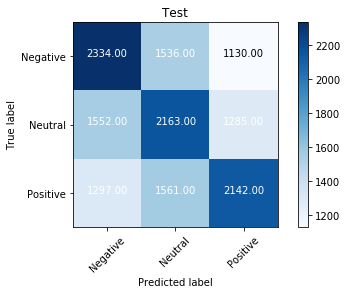

f1 score 0.4426
bernoulli_ngrams_negate
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2368 1448 1184]
 [1592 2094 1314]
 [1399 1480 2121]]


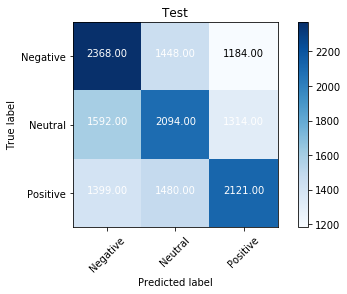

f1 score 0.4388666666666667
tfidf
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[3017 1726  257]
 [2129 2690  181]
 [2037 2181  782]]


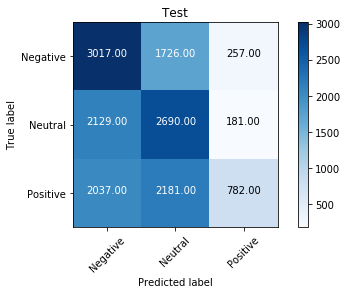

f1 score 0.4326
tfidf_ngrams
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2241 2446  313]
 [1430 3344  226]
 [1439 2682  879]]


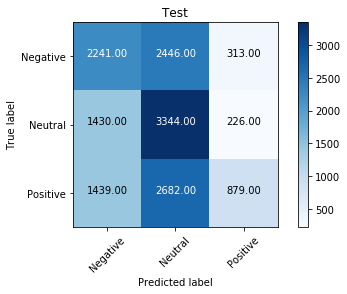

f1 score 0.43093333333333333
tfidf_negate
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[2977 1787  236]
 [2105 2734  161]
 [2085 2221  694]]


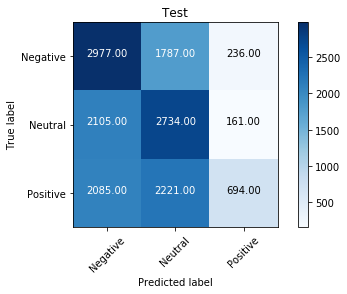

f1 score 0.427
tfidf_ngrams_negate
Train size: 300
Test size: 15000
100
Confusion matrix, without normalization
[[1543 2587  870]
 [ 867 3408  725]
 [ 794 2384 1822]]


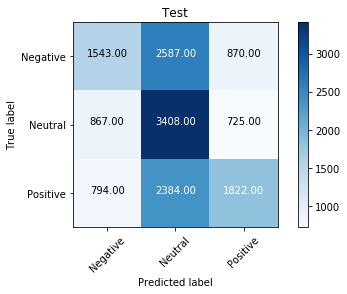

f1 score 0.45153333333333334
original
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3103 1233  664]
 [1632 2154 1214]
 [ 880 1370 2750]]


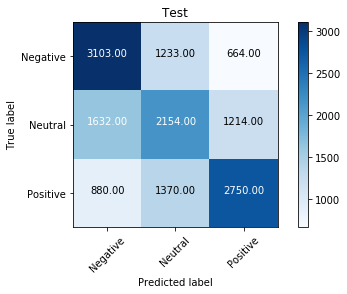

f1 score 0.5338
negation
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3104 1204  692]
 [1571 2184 1245]
 [ 907 1386 2707]]


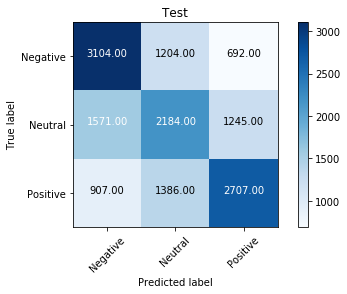

f1 score 0.533
bernoulli
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3037 1291  672]
 [1584 2202 1214]
 [ 883 1336 2781]]


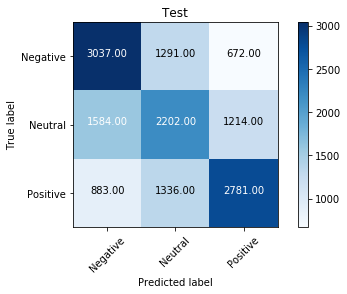

f1 score 0.5346666666666666
bernoulli_ngrams
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3106 1232  662]
 [1627 2127 1246]
 [ 948 1303 2749]]


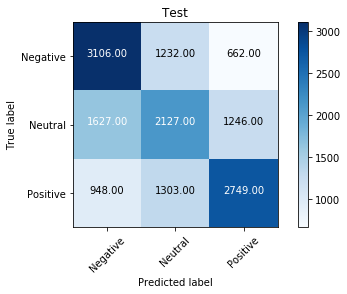

f1 score 0.5321333333333333
bernoulli_negate
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3067 1236  697]
 [1572 2181 1247]
 [ 871 1339 2790]]


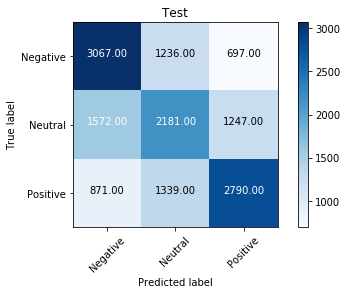

f1 score 0.5358666666666667
bernoulli_ngrams_negate
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3091 1235  674]
 [1582 2153 1265]
 [ 941 1327 2732]]


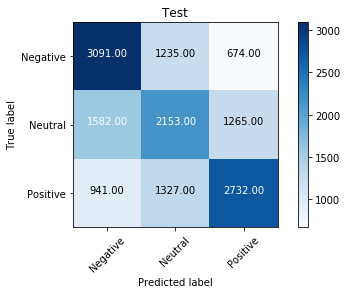

f1 score 0.5317333333333333
tfidf
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3145 1253  602]
 [1544 2282 1174]
 [ 820 1401 2779]]


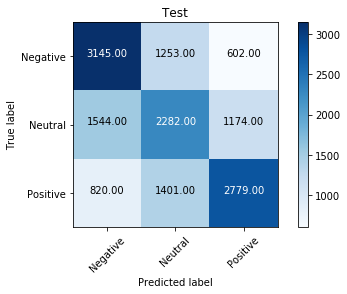

f1 score 0.5470666666666667
tfidf_ngrams
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[2232 1555 1213]
 [1219 2615 1166]
 [ 652 1904 2444]]


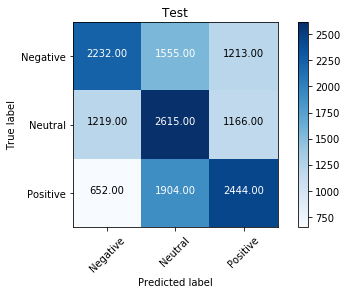

f1 score 0.48606666666666665
tfidf_negate
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3135 1256  609]
 [1519 2329 1152]
 [ 806 1398 2796]]


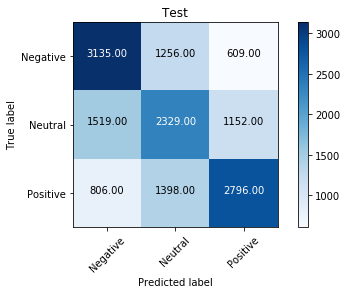

f1 score 0.5506666666666666
tfidf_ngrams_negate
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3063 1309  628]
 [1505 2235 1260]
 [ 856 1359 2785]]


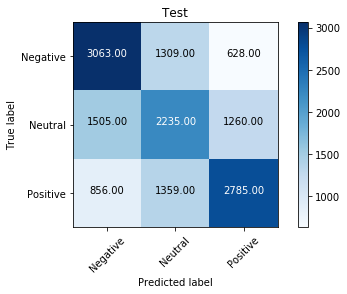

f1 score 0.5388666666666667
original
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3057  947  996]
 [1438 2020 1542]
 [ 693  982 3325]]


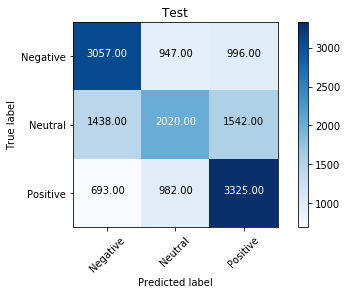

f1 score 0.5601333333333334
negation
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3015  991  994]
 [1399 2072 1529]
 [ 694 1000 3306]]


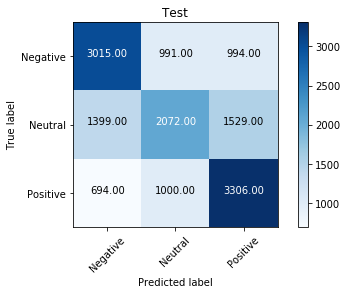

f1 score 0.5595333333333333
bernoulli
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3196  925  879]
 [1393 2150 1457]
 [ 634 1034 3332]]


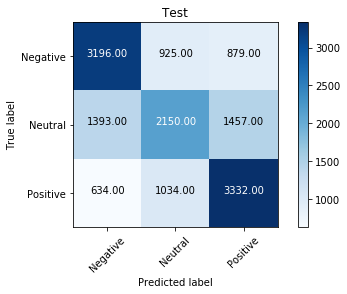

f1 score 0.5785333333333333
bernoulli_ngrams
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3222  931  847]
 [1380 2173 1447]
 [ 639  988 3373]]


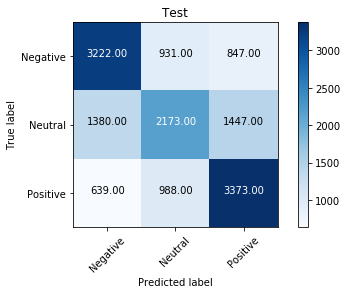

f1 score 0.5845333333333333
bernoulli_negate
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3156  918  926]
 [1349 2151 1500]
 [ 610 1035 3355]]


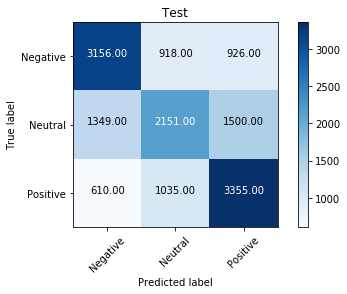

f1 score 0.5774666666666667
bernoulli_ngrams_negate
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[3186  921  893]
 [1351 2153 1496]
 [ 648  992 3360]]


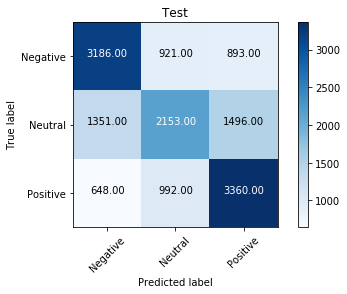

f1 score 0.5799333333333333
tfidf
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[1991 2191  818]
 [ 937 3362  701]
 [ 532 2576 1892]]


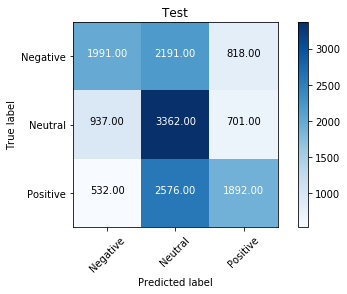

f1 score 0.483
tfidf_ngrams
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[2232 1555 1213]
 [1219 2615 1166]
 [ 652 1904 2444]]


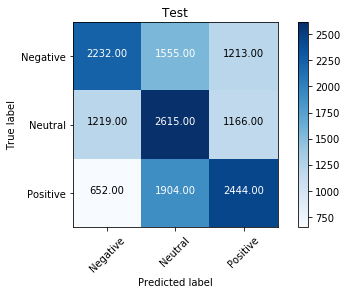

f1 score 0.48606666666666665
tfidf_negate
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[2066 2093  841]
 [1005 3247  748]
 [ 579 2507 1914]]


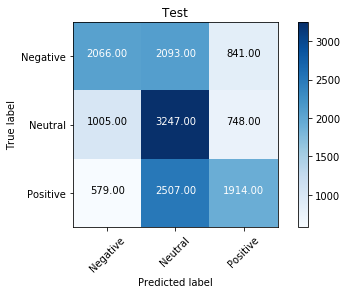

f1 score 0.4818
tfidf_ngrams_negate
Train size: 3000
Test size: 15000
1000
Confusion matrix, without normalization
[[2876 1906  218]
 [1161 3427  412]
 [ 863 2388 1749]]


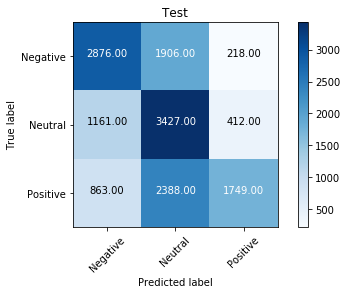

f1 score 0.5368
original
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[462 333 250]
 [345 418 282]
 [301 311 433]]


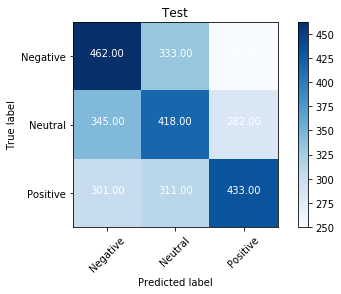

f1 score 0.41881977671451354
negation
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[457 330 258]
 [329 412 304]
 [298 319 428]]


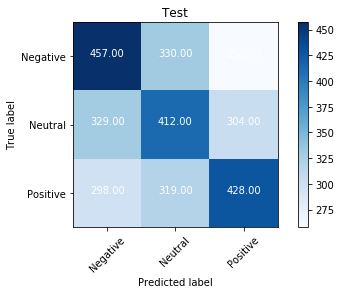

f1 score 0.4137161084529505
bernoulli
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[485 308 252]
 [340 398 307]
 [302 345 398]]


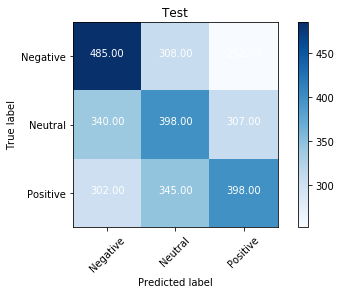

f1 score 0.40861244019138754
bernoulli_ngrams
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[495 293 257]
 [331 400 314]
 [332 346 367]]


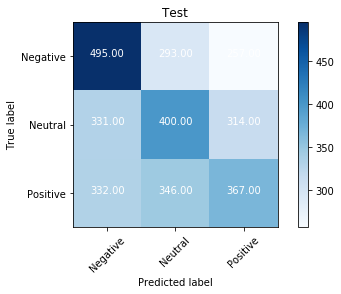

f1 score 0.4025518341307815
bernoulli_negate
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[474 325 246]
 [338 397 310]
 [297 352 396]]


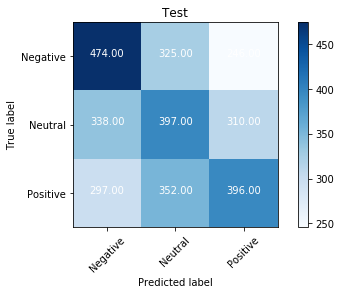

f1 score 0.4041467304625199
bernoulli_ngrams_negate
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[486 315 244]
 [352 387 306]
 [331 356 358]]


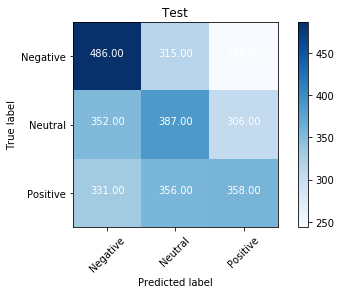

f1 score 0.3926634768740032
tfidf
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[488 302 255]
 [336 417 292]
 [301 312 432]]


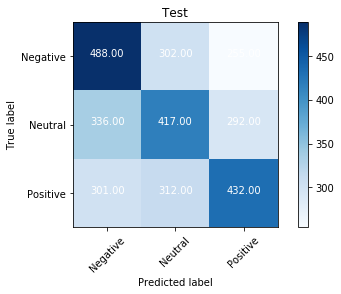

f1 score 0.42647527910685806
tfidf_ngrams
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[510 338 197]
 [328 525 192]
 [300 393 352]]


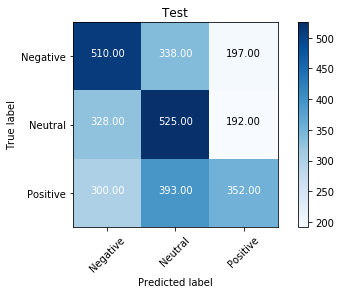

f1 score 0.44242424242424244
tfidf_negate
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[474 316 255]
 [334 403 308]
 [304 324 417]]


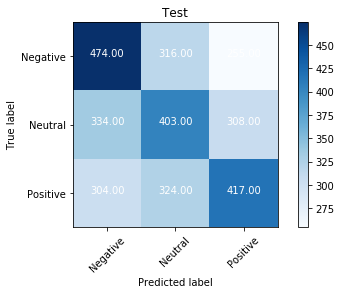

f1 score 0.4127591706539075
tfidf_ngrams_negate
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[480 323 242]
 [324 411 310]
 [331 351 363]]


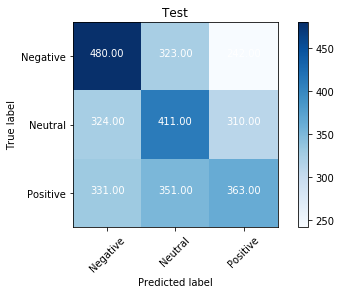

f1 score 0.4000000000000001
original
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[461 335 249]
 [263 474 308]
 [239 339 467]]


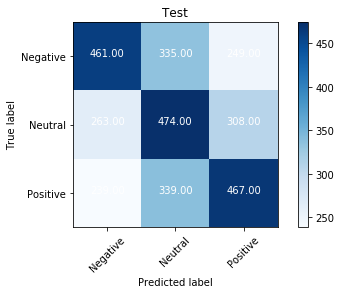

f1 score 0.4472089314194578
negation
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[470 336 239]
 [286 477 282]
 [261 340 444]]


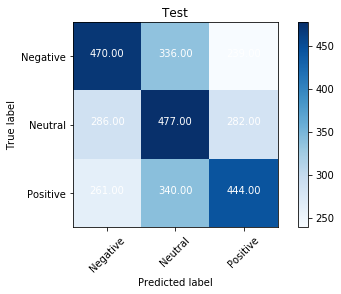

f1 score 0.44370015948963315
bernoulli
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[461 390 194]
 [255 549 241]
 [234 378 433]]


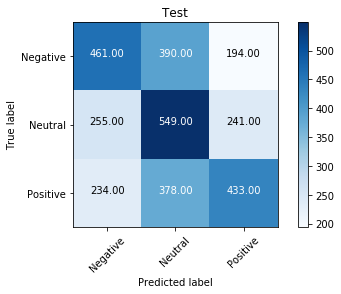

f1 score 0.4602870813397129
bernoulli_ngrams
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[461 367 217]
 [249 524 272]
 [241 367 437]]


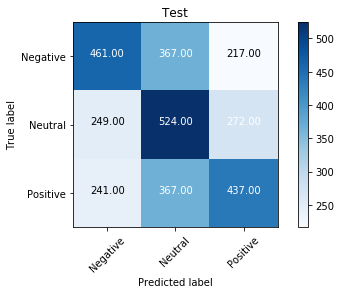

f1 score 0.4535885167464115
bernoulli_negate
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[452 398 195]
 [263 535 247]
 [248 381 416]]


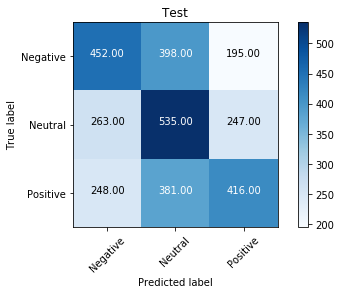

f1 score 0.44752791068580544
bernoulli_ngrams_negate
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[460 375 210]
 [261 517 267]
 [274 354 417]]


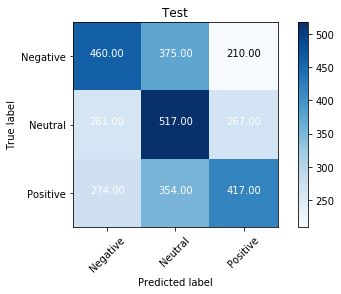

f1 score 0.44465709728867625
tfidf
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[714 237  94]
 [469 475 101]
 [438 366 241]]


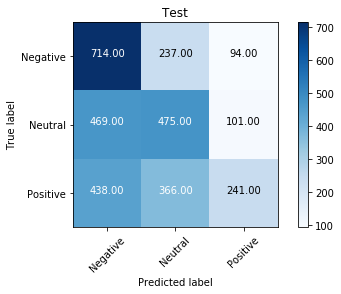

f1 score 0.45614035087719296
tfidf_ngrams
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[510 338 197]
 [328 525 192]
 [300 393 352]]


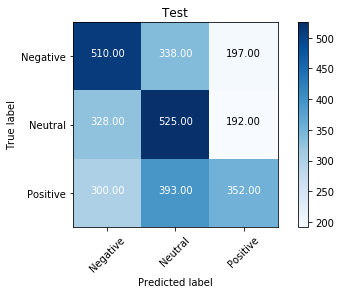

f1 score 0.44242424242424244
tfidf_negate
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[677 272  96]
 [446 503  96]
 [420 395 230]]


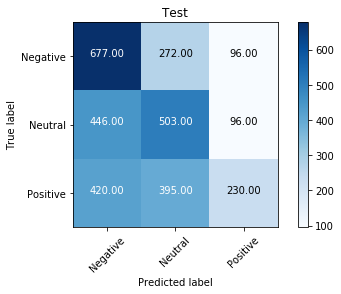

f1 score 0.44976076555023925
tfidf_ngrams_negate
Train size: 300
Test size: 3135
100
Confusion matrix, without normalization
[[360 350 335]
 [205 504 336]
 [174 384 487]]


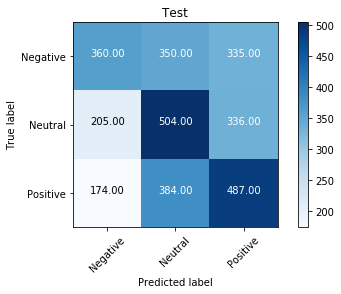

f1 score 0.4309409888357257
original
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[589 296 160]
 [320 466 259]
 [230 273 542]]


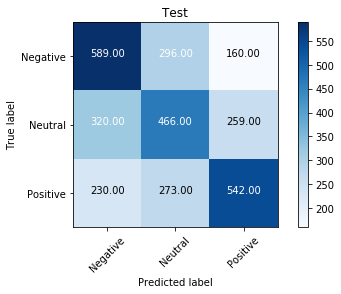

f1 score 0.5094098883572568
negation
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[587 299 159]
 [316 466 263]
 [216 282 547]]


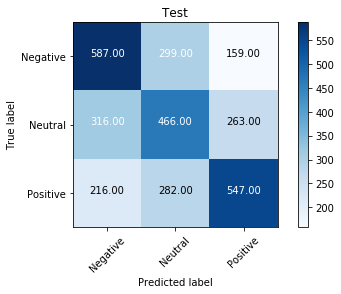

f1 score 0.5103668261562998
bernoulli
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[593 287 165]
 [315 476 254]
 [221 283 541]]


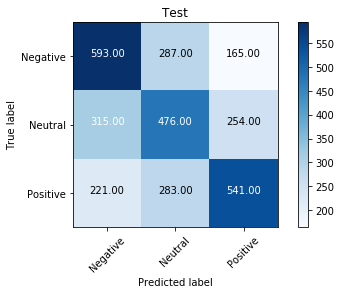

f1 score 0.5135566188197768
bernoulli_ngrams
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[591 296 158]
 [340 451 254]
 [220 314 511]]


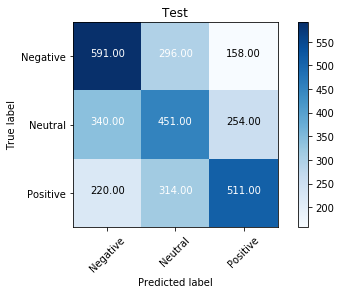

f1 score 0.4953748006379585
bernoulli_negate
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[593 297 155]
 [321 465 259]
 [209 284 552]]


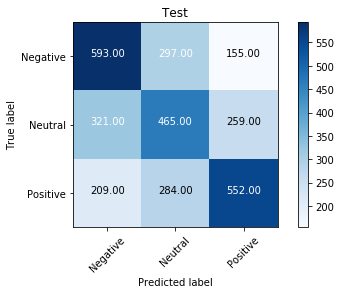

f1 score 0.5135566188197768
bernoulli_ngrams_negate
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[577 307 161]
 [346 447 252]
 [231 300 514]]


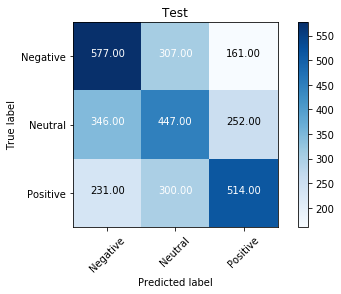

f1 score 0.49059011164274324
tfidf
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[586 296 163]
 [320 469 256]
 [229 282 534]]


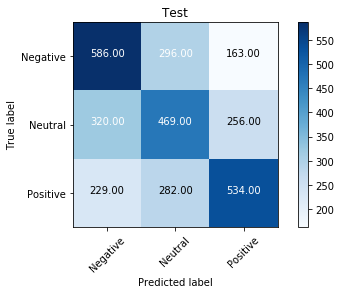

f1 score 0.5068580542264752
tfidf_ngrams
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[918 102  25]
 [738 260  47]
 [699 173 173]]


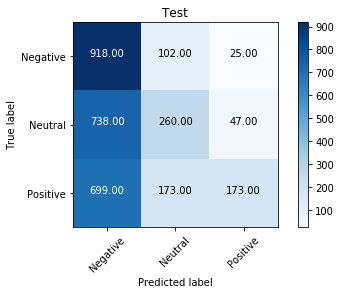

f1 score 0.4309409888357257
tfidf_negate
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[581 301 163]
 [302 467 276]
 [211 290 544]]


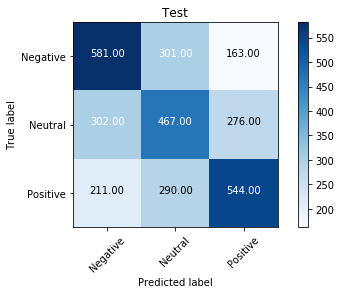

f1 score 0.5078149920255184
tfidf_ngrams_negate
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[599 292 154]
 [346 467 232]
 [234 312 499]]


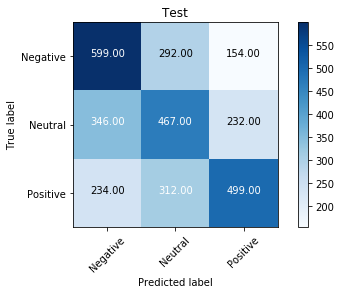

f1 score 0.49920255183413076
original
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[751 192 102]
 [484 440 121]
 [397 256 392]]


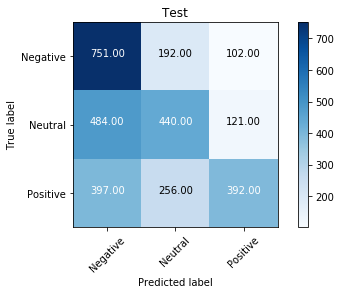

f1 score 0.5049441786283891
negation
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[762 182 101]
 [504 424 117]
 [418 249 378]]


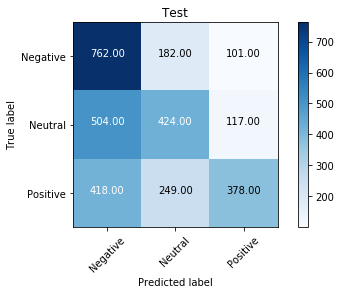

f1 score 0.4988835725677831
bernoulli
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[750 174 121]
 [500 408 137]
 [414 225 406]]


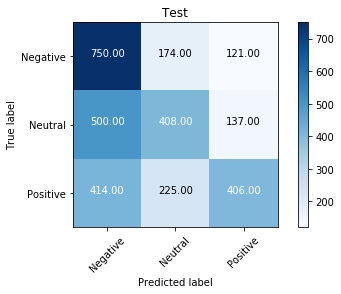

f1 score 0.4988835725677831
bernoulli_ngrams
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[791 137 117]
 [546 354 145]
 [436 179 430]]


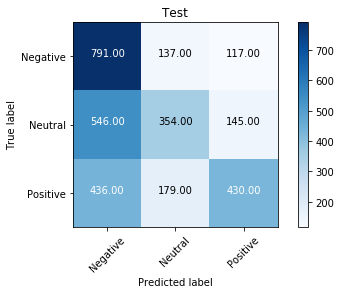

f1 score 0.5023923444976076
bernoulli_negate
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[762 168 115]
 [528 380 137]
 [428 215 402]]


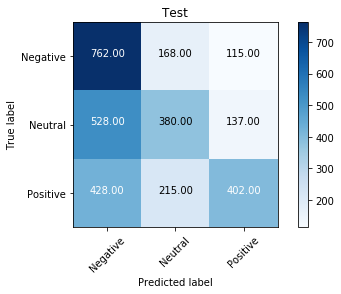

f1 score 0.49250398724082933
bernoulli_ngrams_negate
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[800 134 111]
 [565 338 142]
 [455 176 414]]


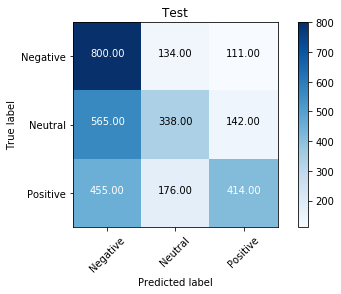

f1 score 0.49505582137161086
tfidf
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[978  45  22]
 [786 218  41]
 [767 129 149]]


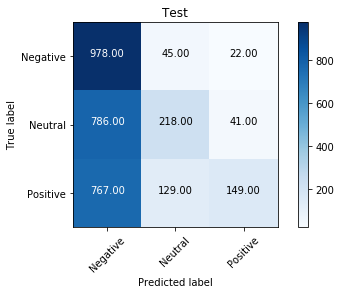

f1 score 0.42902711323763953
tfidf_ngrams
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[918 102  25]
 [738 260  47]
 [699 173 173]]


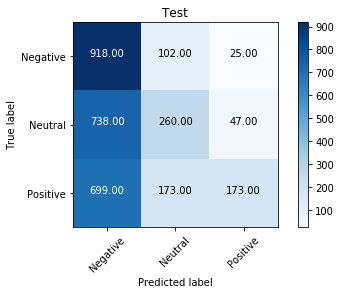

f1 score 0.4309409888357257
tfidf_negate
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[965  59  21]
 [765 245  35]
 [766 147 132]]


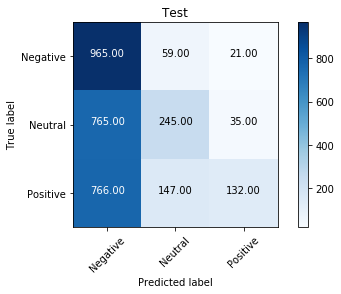

f1 score 0.4280701754385965
tfidf_ngrams_negate
Train size: 3000
Test size: 3135
1000
Confusion matrix, without normalization
[[880 101  64]
 [664 245 136]
 [521 170 354]]


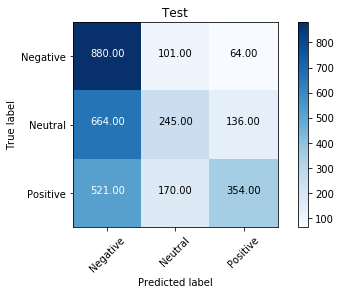

f1 score 0.4717703349282297


In [9]:
tasks = ['amazon_movies', 'semeval_task_a']
sub_tasks = ['fair_balanced_100', 'fair_balanced_1000'] #'fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'
features = ['original', 'negation', 'bernoulli', 'bernoulli_ngrams', 'bernoulli_negate', 'bernoulli_ngrams_negate', 'tfidf', 'tfidf_ngrams', 'tfidf_negate', 'tfidf_ngrams_negate']

stemmer = Stemmer()

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir
datasets_dir = repo_dir / "datasets"

f1_scores = []

for task in tasks:
    for subtask in sub_tasks:
        f1_column = []
        for kernel in ['linear', 'rbf']:
            for feature in features:
                print(feature)
                df_trn = pd.read_csv(datasets_dir / task / subtask / "train.csv")
                df_val = pd.read_csv(datasets_dir / task / subtask / "validate.csv")
                print("Train size:", len(df_trn))
                print("Test size:", len(df_val))

                df_trn['text'] = df_trn['text'].astype(str)
                df_val['text'] = df_val['text'].astype(str)

                df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                              remove_users=True, 
                                                                                              remove_urls=True, 
                                                                                              remove_numbers=True))
                df_val['text'] = df_val['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                              remove_users=True, 
                                                                                              remove_urls=True, 
                                                                                              remove_numbers=True))

                tier = int(subtask.split('_')[-1])
                print(tier)

                if feature == 'original':
                    cv = CountVectorizer(stop_words=None, 
                                         ngram_range=(1,1),
                                         max_features=3*tier,
                                         tokenizer=lambda e: tokenizer_word(e,
                                                                            keep_phrases=False,
                                                                            tokenize_punc=True,
                                                                            split_clitics=False,
                                                                            keep_preceeding_space=False),
                                         binary=False)

                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel=kernel, C=10)

                    model.fit(cv_data_trn, df_trn['label'])
                if feature == 'negation':
                    cv = CountVectorizer(stop_words=None, 
                                         ngram_range=(1,1),
                                         max_features=3*tier,
                                         tokenizer=lambda e: negate_sequence(e),
                                         binary=False)

                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel=kernel, C=10)

                    model.fit(cv_data_trn, df_trn['label'])

                if feature == 'bernoulli':
                    cv = CountVectorizer(stop_words=None, 
                                         ngram_range=(1,1),
                                         max_features=3*tier,
                                         tokenizer=lambda e: tokenizer_word(e,
                                                                            keep_phrases=False,
                                                                            tokenize_punc=True,
                                                                            split_clitics=False,
                                                                            keep_preceeding_space=False),
                                         binary=True)


                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel=kernel, C=10)

                    model.fit(cv_data_trn, df_trn['label'])

                if feature == 'bernoulli_ngrams':
                    cv = CountVectorizer(stop_words=None, 
                                         ngram_range=(1,3),
                                         max_features=3*tier,
                                         tokenizer=lambda e: tokenizer_word(e,
                                                                            keep_phrases=False,
                                                                            tokenize_punc=True,
                                                                            split_clitics=False,
                                                                            keep_preceeding_space=False),
                                         binary=True)

                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel=kernel, C=10)

                    model.fit(cv_data_trn, df_trn['label'])

                if feature == 'bernoulli_negate':
                    cv = CountVectorizer(stop_words=None, 
                                         ngram_range=(1,1),
                                         max_features=3*tier,
                                         tokenizer=lambda e: negate_sequence(e),
                                         binary=True)


                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel=kernel, C=10)

                    model.fit(cv_data_trn, df_trn['label'])

                if feature == 'bernoulli_ngrams_negate':
                    cv = CountVectorizer(stop_words=None, 
                                         ngram_range=(1,3),
                                         max_features=3*tier,
                                         tokenizer=lambda e: negate_sequence(e),
                                         binary=True)

                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel=kernel, C=10)

                    model.fit(cv_data_trn, df_trn['label'])

                if feature == 'tfidf':
                    cv = TfidfVectorizer(stop_words=None, 
                                         ngram_range=(1,1),
                                         max_features=3*tier,
                                         tokenizer=lambda e: tokenizer_word(e,
                                                                            keep_phrases=False,
                                                                            tokenize_punc=True,
                                                                            split_clitics=False,
                                                                            keep_preceeding_space=False))


                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel=kernel, C=10) 
                    model.fit(cv_data_trn, df_trn['label'])

                if feature == 'tfidf_ngrams':
                    cv = TfidfVectorizer(stop_words=None, 
                                         ngram_range=(1,3),
                                         max_features=3*tier,
                                         tokenizer=lambda e: tokenizer_word(e,
                                                                            keep_phrases=False,
                                                                            tokenize_punc=True,
                                                                            split_clitics=False,
                                                                            keep_preceeding_space=False))

                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel='rbf', C=10)

                    model.fit(cv_data_trn, df_trn['label'])

                if feature == 'tfidf_negate':
                    cv = TfidfVectorizer(stop_words=None, 
                                         ngram_range=(1,1),
                                         max_features=3*tier,
                                         tokenizer=lambda e: negate_sequence(e))


                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel=kernel, C=10)

                    model.fit(cv_data_trn, df_trn['label'])

                if feature == 'tfidf_ngrams_negate':
                    cv = TfidfVectorizer(stop_words=None, 
                                         ngram_range=(1,3),
                                         max_features=3*tier,
                                         tokenizer=lambda e: negate_sequence(e),
                                         binary=True)

                    cv_data_trn = cv.fit_transform(df_trn["text"])
                    cv_data_val = cv.transform(df_val["text"])

                    model = SVC(kernel=kernel, C=10)

                    model.fit(cv_data_trn, df_trn['label'])

                preds = model.predict(cv_data_val)
                cm_val = confusion_matrix(y_true=df_val["label"], y_pred=preds)
                plot_confusion_matrix(cm_val,
                                      ['Negative', 'Neutral', 'Positive'],
                                      normalize=False,
                                      title='Test')
                f1 = f1_score(df_val["label"], preds, average="micro")
                print("f1 score", f1)
                f1_column.append(f1)
        f1_scores.append(f1_column)

In [10]:
pd.DataFrame(np.array(f1_scores).T)

,0,1,2,3
0,0.435133,0.533800,0.418820,0.509410
1,0.432600,0.533000,0.413716,0.510367
2,0.419200,0.534667,0.408612,0.513557
3,0.413667,0.532133,0.402552,0.495375
4,0.419467,0.535867,0.404147,0.513557
5,0.420933,0.531733,0.392663,0.490590
6,0.431067,0.547067,0.426475,0.506858
7,0.430933,0.486067,0.442424,0.430941
8,0.428067,0.550667,0.412759,0.507815
9,0.418133,0.538867,0.400000,0.499203


# Fine tuning the best architectures on values of c and f

In [ ]:
tasks = ['amazon_movies', 'semeval_task_a']
sub_tasks = ['fair_balanced_100', 'fair_balanced_1000'] #'fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'

stemmer = Stemmer()

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir
datasets_dir = repo_dir / "datasets"

f1_scores = []

for task in tasks:
    for subtask in sub_tasks:
        f1_matrix = []
        for c in [4, 8, 16, 32, 64, 128]:
            f1_column = []
            for f in [1,2,3,4,5,6,7,8,9,10]:
                df_trn = pd.read_csv(datasets_dir / task / subtask / "train.csv")
                df_val = pd.read_csv(datasets_dir / task / subtask / "validate.csv")
                print("Train size:", len(df_trn))
                print("Test size:", len(df_val))

                df_trn['text'] = df_trn['text'].astype(str)
                df_val['text'] = df_val['text'].astype(str)

                df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                              remove_users=True, 
                                                                                              remove_urls=True, 
                                                                                              remove_numbers=True))
                df_val['text'] = df_val['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                              remove_users=True, 
                                                                                              remove_urls=True, 
                                                                                              remove_numbers=True))

                tier = int(subtask.split('_')[-1])

                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=f*tier,
                                     tokenizer=lambda e: tokenizer_word(e,
                                                                        keep_phrases=False,
                                                                        tokenize_punc=True,
                                                                        split_clitics=False,
                                                                        keep_preceeding_space=False),
                                     binary=True)


                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = SVC(kernel='rbf', C=c)

                model.fit(cv_data_trn, df_trn['label'])

                preds = model.predict(cv_data_val)
                cm_val = confusion_matrix(y_true=df_val["label"], y_pred=preds)
                plot_confusion_matrix(cm_val,
                                      ['Negative', 'Neutral', 'Positive'],
                                      normalize=False,
                                      title='Test')
                f1 = f1_score(df_val["label"], preds, average="micro")
                print("f1 score", f1)
                f1_column.append(f1)
            f1_matrix.append(f1_column)
        f1_scores.append(f1_matrix)

In [ ]:
pd.DataFrame(np.array(f1_scores[0]).T)

In [ ]:
pd.DataFrame(np.array(f1_scores[1]).T)

In [ ]:
pd.DataFrame(np.array(f1_scores[2]).T)

In [ ]:
pd.DataFrame(np.array(f1_scores[3]).T)

# Validating best architectures again with new c and f values

In [ ]:
tasks = ['amazon_movies', 'semeval_task_a']
sub_tasks = ['fair_balanced_100', 'fair_balanced_1000'] #'fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'
features = ['original', 'negation', 'bernoulli', 'ngrams', 'bernoulli_negate', 'ngrams_negate']

stemmer = Stemmer()

hyper_map = {'amazon_movies':{'fair_balanced_100':{'c':4, 'f':7}, 'fair_balanced_1000':{'c':64, 'f':8}},
             'semeval_task_a':{'fair_balanced_100':{'c':32, 'f':9}, 'fair_balanced_1000':{'c':128, 'f':5}}}

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir
datasets_dir = repo_dir / "datasets"

f1_scores = []

for task in tasks:
    for subtask in sub_tasks:
        f1_column = []
        for feature in features:
            
            c = hyper_map[task][subtask]['c']
            f = hyper_map[task][subtask]['f']
            
            df_trn = pd.read_csv(datasets_dir / task / subtask / "train.csv")
            df_val = pd.read_csv(datasets_dir / task / subtask / "validate.csv")
            print("Train size:", len(df_trn))
            print("Test size:", len(df_val))

            df_trn['text'] = df_trn['text'].astype(str)
            df_val['text'] = df_val['text'].astype(str)

            df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                          remove_users=True, 
                                                                                          remove_urls=True, 
                                                                                          remove_numbers=True))
            df_val['text'] = df_val['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                          remove_users=True, 
                                                                                          remove_urls=True, 
                                                                                          remove_numbers=True))

            tier = int(subtask.split('_')[-1])
            print(tier)
            
            if feature == 'original':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=f*tier,
                                     tokenizer=lambda e: tokenizer_word(e,
                                                                        keep_phrases=False,
                                                                        tokenize_punc=True,
                                                                        split_clitics=False,
                                                                        keep_preceeding_space=False),
                                     binary=False)

                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = SVC(kernel='rbf', C=c)

                model.fit(cv_data_trn, df_trn['label'])
            if feature == 'negation':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=f*tier,
                                     tokenizer=lambda e: negate_sequence(e),
                                     binary=False)

                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = SVC(kernel='rbf', C=c)

                model.fit(cv_data_trn, df_trn['label'])
            if feature == 'bernoulli':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=f*tier,
                                     tokenizer=lambda e: tokenizer_word(e,
                                                                        keep_phrases=False,
                                                                        tokenize_punc=True,
                                                                        split_clitics=False,
                                                                        keep_preceeding_space=False),
                                     binary=True)


                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = SVC(kernel='rbf', C=c)

                model.fit(cv_data_trn, df_trn['label'])
            if feature == 'ngrams':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,3),
                                     max_features=f*tier,
                                     tokenizer=lambda e: tokenizer_word(e,
                                                                        keep_phrases=False,
                                                                        tokenize_punc=True,
                                                                        split_clitics=False,
                                                                        keep_preceeding_space=False),
                                     binary=True)

                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = SVC(kernel='rbf', C=c)

                model.fit(cv_data_trn, df_trn['label'])
                
            if feature == 'bernoulli_negate':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,1),
                                     max_features=f*tier,
                                     tokenizer=lambda e: negate_sequence(e),
                                     binary=True)


                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = SVC(kernel='rbf', C=c)

                model.fit(cv_data_trn, df_trn['label'])
            if feature == 'ngrams_negate':
                cv = CountVectorizer(stop_words=None, 
                                     ngram_range=(1,3),
                                     max_features=f*tier,
                                     tokenizer=lambda e: negate_sequence(e),
                                     binary=True)

                cv_data_trn = cv.fit_transform(df_trn["text"])
                cv_data_val = cv.transform(df_val["text"])

                model = SVC(kernel='rbf', C=c)

                model.fit(cv_data_trn, df_trn['label'])

            preds = model.predict(cv_data_val)
            cm_val = confusion_matrix(y_true=df_val["label"], y_pred=preds)
            plot_confusion_matrix(cm_val,
                                  ['Negative', 'Neutral', 'Positive'],
                                  normalize=False,
                                  title='Test')
            f1 = f1_score(df_val["label"], preds, average="micro")
            print("f1 score", f1)
            f1_column.append(f1)
        f1_scores.append(f1_column)

In [ ]:
pd.DataFrame(np.array(f1_scores).T)